In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('..')
import pandas as pd
from model import VAE, plus_encode_data
import seaborn as sns
from sklearn.mixture import GaussianMixture
import joblib
import input_pipeline
from sklearn.manifold import TSNE

2024-06-08 09:16:05.957382: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 09:16:06.004843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 09:16:06.004883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 09:16:06.006862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-08 09:16:06.018434: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 09:16:06.022104: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def load_model_at_T(t, folder,  latent_dim = 200):
    model = VAE(latent_dim)
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights(f'{folder}/{t:.1f}/vae{t:.1f}.h5')
    return model

folder = "Results/22-03-2024"

# Gaussian mixture fitting

In [3]:

temps = np.arange(2.0, 3.05, 0.1)
models = {t: load_model_at_T(t, folder) for t in temps}

In [6]:
gm_vars = GaussianMixture(n_components=2, random_state=0)
gm_means = GaussianMixture(n_components=1, random_state=0)

for temp in temps:
    model = models[temp]
    batch_size = 100
    
    trainset_path = f"../../GetData/Python/Data/Data{temp:.1f}.tfrecord"
    train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)

    # data mc trainset
    data_var = []
    data_mean = []
    for batch in train_set:
        data_mc = batch
        data_plus = plus_encode_data(data_mc)
        mean, var = model.encode(data_plus)
        data_var.append(var)
        data_mean.append(mean)
    
    vars = np.concatenate(data_var, axis=0)
    means = np.concatenate(data_mean, axis=0)

    gm_vars.fit(vars)
    gm_means.fit(means)

    # Save the GMM models
    joblib.dump(gm_vars, f"{folder}/{temp:.1f}/gm_vars.pkl")
    joblib.dump(gm_means, f"{folder}/{temp:.1f}/gm_means.pkl")
    
    print(f"Temperature: {temp:.1f}")

Temperature: 2.0
Temperature: 2.1
Temperature: 2.2
Temperature: 2.3
Temperature: 2.4
Temperature: 2.5
Temperature: 2.6
Temperature: 2.7
Temperature: 2.8
Temperature: 2.9
Temperature: 3.0


# Tsne

In [4]:
temp = 2.3
model = load_model_at_T(temp, folder)
batch_size = 100

trainset_path = f"../../GetData/Python/Data/Data{temp:.1f}.tfrecord"
train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)

# data mc trainset
data_var = []
data_mean = []
for batch in train_set:
    data_mc = batch
    data_plus = plus_encode_data(data_mc)
    mean, var = model.encode(data_plus)
    data_var.append(var)
    data_mean.append(mean)

vars = np.concatenate(data_var, axis=0)
means = np.concatenate(data_mean, axis=0)

In [5]:
tsne_mean = TSNE(n_components=2, perplexity=50, n_iter=10000, verbose=1, random_state=123)
means_sampled = means[np.random.choice(means.shape[0], 5000, replace=False)]
v = tsne_mean.fit_transform(means_sampled) 

df_mean = pd.DataFrame()
df_mean["x"] = v[:,0]
df_mean["y"] = v[:,1]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.443s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.287985
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.225105
[t-SNE] KL divergence after 2450 iterations: 3.752140


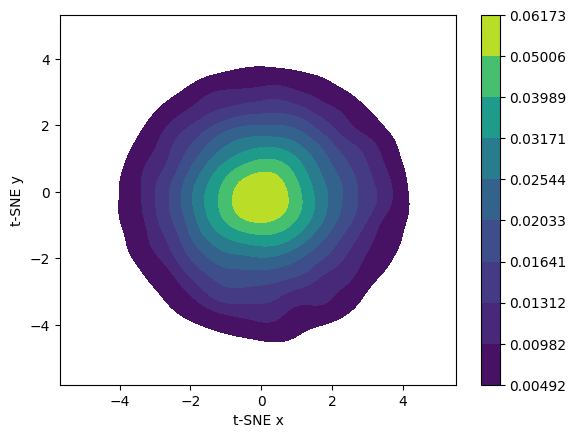

In [29]:
sns.kdeplot(data=df_mean, x='x', y='y', cmap='viridis', fill=True, cbar=True)
plt.xlabel("t-SNE x")
plt.ylabel("t-SNE y")
plt.savefig(f"{folder}/means_tsne.png")

In [19]:
tsne_var = TSNE(n_components=2, perplexity=50, n_iter=10000, verbose=1, random_state=123)
vars_sampled = vars[np.random.choice(vars.shape[0], 5000, replace=False)]
v = tsne_var.fit_transform(vars_sampled) 
df_var = pd.DataFrame()
df_var["x"] = v[:,0]
df_var["y"] = v[:,1]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.301s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.358607
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.755219
[t-SNE] KL divergence after 9850 iterations: 1.804986


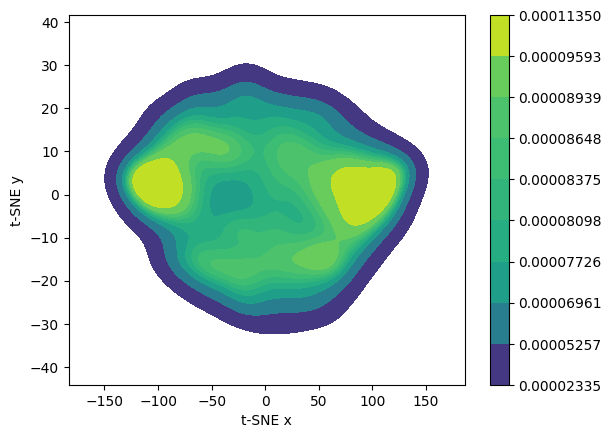

In [30]:
sns.kdeplot(data=df_var, x='x', y='y', cmap='viridis', fill=True, cbar=True)
plt.xlabel("t-SNE x")
plt.ylabel("t-SNE y")
plt.savefig(f"{folder}/vars_tsne.png")

/home/ps/.local/lib/python3.11/site-packages/seaborn/distributions.py:1138: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)


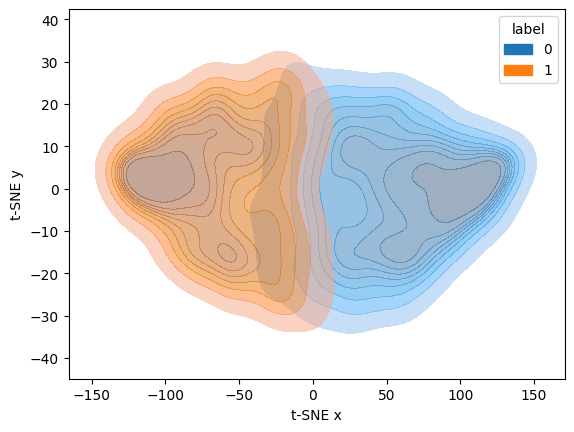

In [31]:
gm_vars = GaussianMixture(n_components=2, random_state=0)
gm_vars.fit(vars_sampled)
labels = gm_vars.predict(vars_sampled)
df_var['label'] = labels
sns.kdeplot(data=df_var, x='x', y='y', cmap='viridis', fill=True, cbar=False, hue='label', alpha=0.5)
plt.xlabel("t-SNE x")
plt.ylabel("t-SNE y")
plt.savefig(f"{folder}/vars_tsne_gm.png")